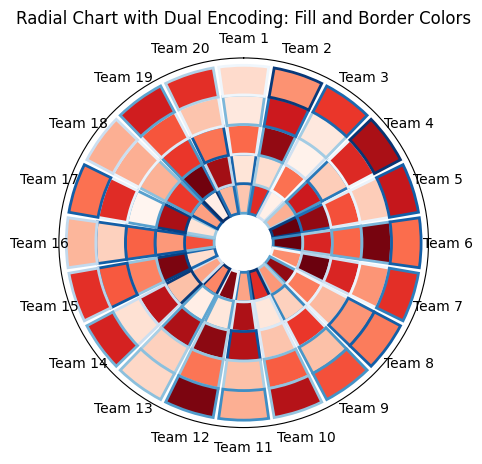

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Exemplo de dados para 5 posições e 5 times
avgs = np.random.randint(0, 91, size=(5, 20))  # Valores entre 0 e 90 para preenchimento
aux = np.random.randint(0, 51, size=(5, 20))  # Valores entre 0 e 50 para cor da borda

# Número de posições e times
num_positions, num_teams = avgs.shape

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

width = 2 * np.pi / num_teams
inner_radius = 1
ring_width = 1

# Normalizar os valores para as escalas de cores
norm_avg = avgs / 90
norm_aux = aux / 50

# Criar os anéis do gráfico radial
for i in range(num_positions):
    for j in range(num_teams):
        theta = j * width
        fill_color = plt.cm.Reds(norm_avg[i, j])  # Cor de preenchimento
        border_color = plt.cm.Blues(norm_aux[i, j])  # Cor da borda
        ax.bar(theta, ring_width,  # Altura do anel
               width=width * 0.9,  # Largura angular
               bottom=inner_radius + ring_width * i,  # Posição do anel
               color=fill_color,
               edgecolor=border_color,
               linewidth=2)

# Configurar os rótulos e o grid
ax.set_xticks(np.linspace(0, 2 * np.pi, num_teams, endpoint=False))
ax.set_xticklabels([f'Team {i+1}' for i in range(num_teams)])
ax.set_yticklabels([])
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.grid(False)

plt.title('Radial Chart with Dual Encoding: Fill and Border Colors')
plt.show()